<a href="https://colab.research.google.com/github/ellieytc/CaseStudy.DeepLearning/blob/master/Food_VGG16_0_86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Aug 19 18:59:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Library

In [7]:
import numpy as np 
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

## Download Data

In [5]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Tibame/dataset/food_imgtt.zip'

zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.chdir('/tmp')
os.listdir('/tmp')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['drivefs_ipc.0_shell',
 'food_train',
 'food_test',
 'sampleSubmission.csv',
 'tmpoorq3djp',
 'drivefs_ipc.0']

## Prepare Training Data

In [23]:
filenames = os.listdir('/tmp/food_train/')
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'apple':
      categories.append(0)
    elif category == 'cabbage':
      categories.append(1)
    elif category == 'carrot':
      categories.append(2)
    elif category == 'chicken':
      categories.append(3)
    elif category == 'cucumber':
      categories.append(4)
    elif category == 'egg':
      categories.append(5)
    elif category == 'mushroom':
      categories.append(6)
    elif category == 'potato':
      categories.append(7)
    elif category == 'radish':
      categories.append(8)       
    else:
      categories.append(9)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
}, dtype=str)
df.head()

,filename,category
0,cabbage_209.jpg,1
1,chicken_30.jpg,3
2,cucumber_257.jpg,4
3,tomato_582.jpg,9
4,egg_952.jpg,5


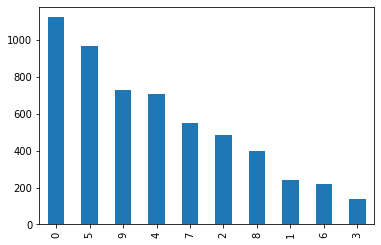

In [24]:
df['category'].value_counts().plot.bar()

## See sample image

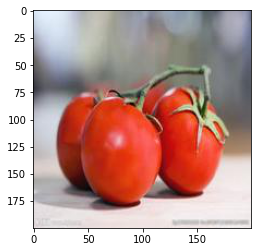

In [26]:
sample = random.choice(filenames)
image = load_img('/tmp/food_train/' + sample)
plt.imshow(image)

## Build Model

In [50]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(10, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Prepare Test and Train Data

In [35]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

## Traning Generator

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '/tmp/food_train/', 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 4995 validated image filenames belonging to 10 classes.


## Validation Generator

In [37]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    '/tmp/food_train/', 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 555 validated image filenames belonging to 10 classes.


## See sample generated images

Found 1 validated image filenames belonging to 1 classes.


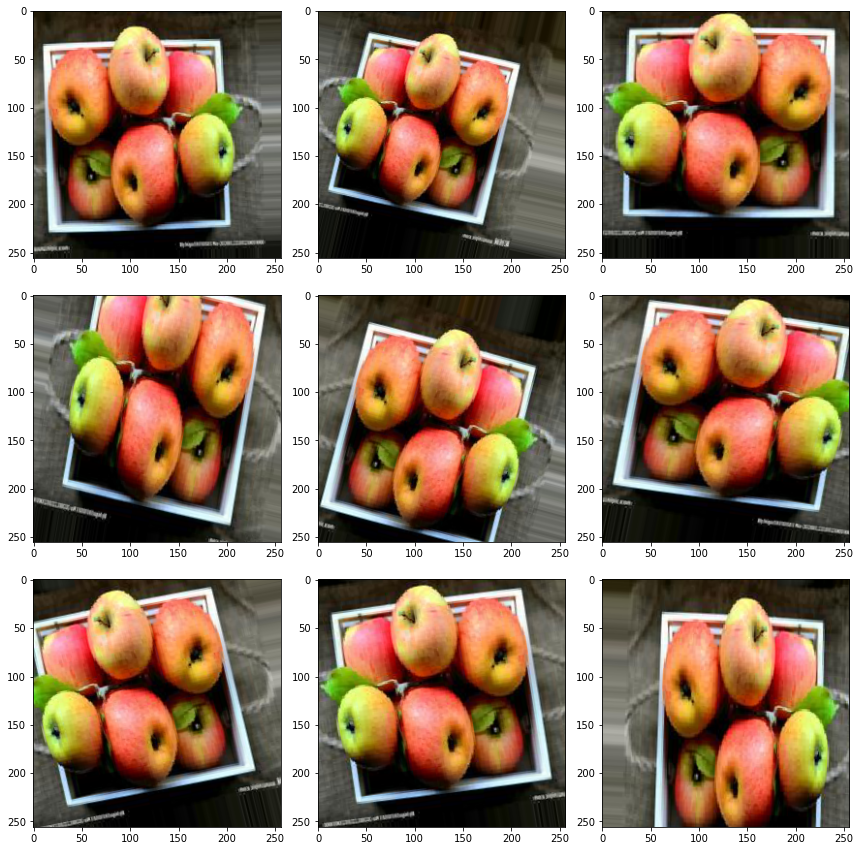

In [38]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    '/tmp/food_train/', 
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [51]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
312/312 [==============================] - 61s 196ms/step - loss: 2.1106 - accuracy: 0.2270 - val_loss: 1.8194 - val_accuracy: 0.2831
Epoch 2/5
312/312 [==============================] - 61s 196ms/step - loss: 1.7044 - accuracy: 0.3902 - val_loss: 1.2271 - val_accuracy: 0.5680
Epoch 3/5
312/312 [==============================] - 62s 197ms/step - loss: 1.2574 - accuracy: 0.5666 - val_loss: 0.8474 - val_accuracy: 0.7555
Epoch 4/5
312/312 [==============================] - 61s 195ms/step - loss: 0.9648 - accuracy: 0.6835 - val_loss: 0.6416 - val_accuracy: 0.8162
Epoch 5/5
312/312 [==============================] - 61s 196ms/step - loss: 0.7559 - accuracy: 0.7604 - val_loss: 0.4572 - val_accuracy: 0.8640


In [52]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.863971  ;  loss = 0.459917 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


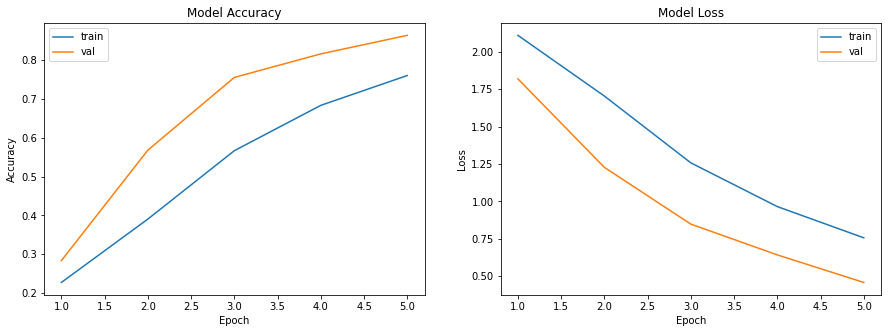

In [53]:
def plot_model_history(model_history, accuracy='accuracy', val_accurary='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accurary])+1),model_history.history[val_accurary])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [54]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [64]:
y_final = np.argmax(y_pred, axis=1)
y_final.size

555

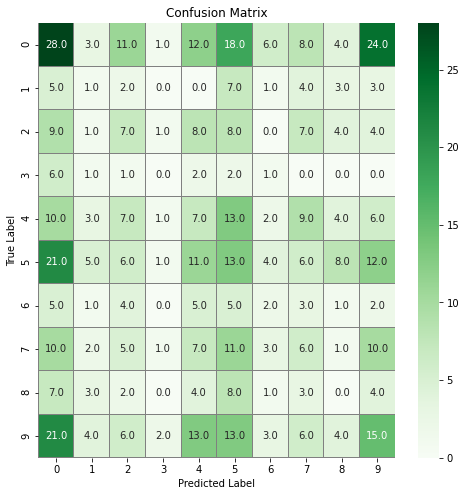

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val.astype(str), y_final.astype(str)) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [72]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val.astype(str), y_final.astype(str), target_names=['0','1','2','3','4','5','6','7','8','9'])

print(report)

              precision    recall  f1-score   support

           0       0.23      0.24      0.24       115
           1       0.04      0.04      0.04        26
           2       0.14      0.14      0.14        49
           3       0.00      0.00      0.00        13
           4       0.10      0.11      0.11        62
           5       0.13      0.15      0.14        87
           6       0.09      0.07      0.08        28
           7       0.12      0.11      0.11        56
           8       0.00      0.00      0.00        32
           9       0.19      0.17      0.18        87

    accuracy                           0.14       555
   macro avg       0.10      0.10      0.10       555
weighted avg       0.14      0.14      0.14       555



## Prepare Testing Data

In [65]:
test_filenames = os.listdir('/tmp/food_test/')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [60]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/tmp/food_test/', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 1422 validated image filenames.


## Predict

In [66]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
test_df['category'] = np.argmax(predict, axis=1)

## See predicted result

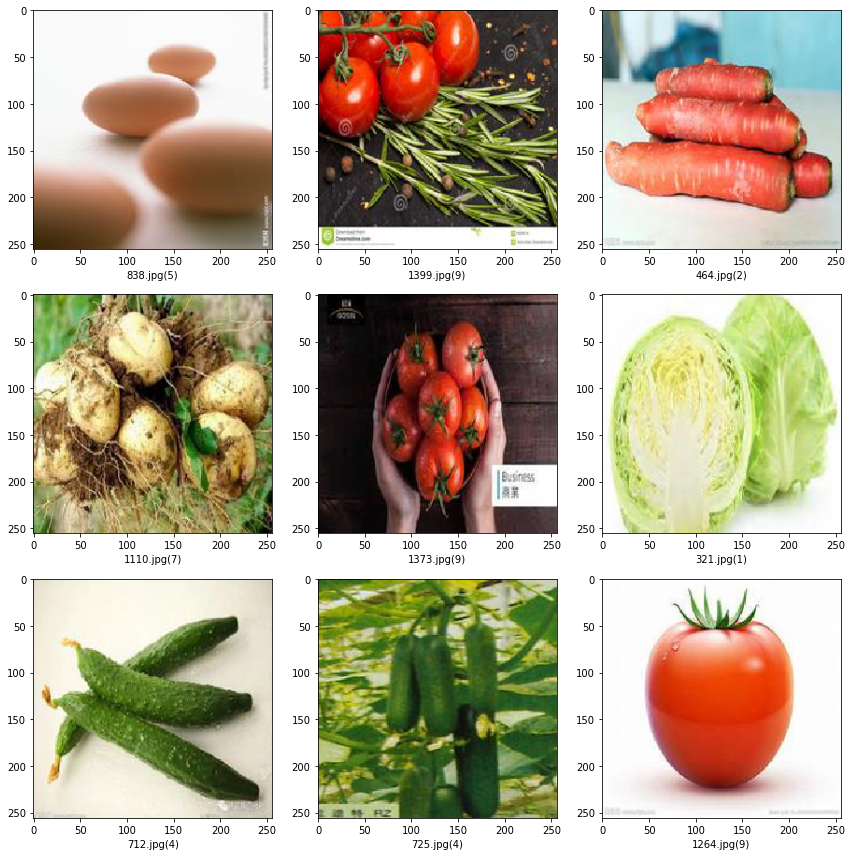

In [67]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('/tmp/food_test/' + filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

## Submission

Text(0.5, 1.0, '(Test data)')

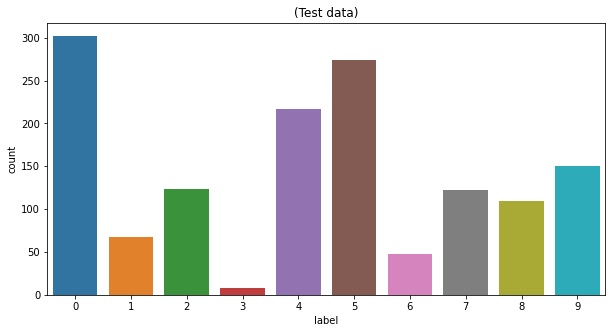

In [68]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")